In [56]:
# Numerical
from jax.numpy import mean, var, exp, newaxis   # Arithematic
from jax.numpy import array, zeros, arange  # Array creation routines
from jax.numpy.linalg import solve, eig
from jax.lax import scan 
from jax import jit, jacrev, jacfwd

# Miscellaneous
from functools import partial 
from time import process_time
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter

# ODEINTs
from ticktack.bogacki_shampine import odeint as BS3
from ticktack.dormand_prince import odeint as DP5

# Visualisation
from pandas import DataFrame
from plotnine import *

In [57]:
parameters = (774.86, 0.25, 0.8, 6.44)

In [73]:
def profile(func, *args, **kwargs) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.

    Parameters:
        func: Function -> The function that will be repeatedly run and profiled 
        *args: Any -> The positional arguments of function
        **kwargs: Any -> The keyword arguments of the functioin 
    
    Returns:
        dict -> Assuming compilation the mean and variance of the 9 runs following the compilation. The output of the final call to function is also returned.
    """
    time_sample = zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()             # Starting a timer 
        solution = func(*args, **kwargs)   # Running the model 
        map(array, solution) # Forcing vistation of the values (equivalent to block_until_ready)
        timer = process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": mean(time_sample.at[1:].get()), 
        "variance": var(time_sample.at[1:].get()),
        "solution": solution
        }


def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    """
    A linear ode solver that is designed to be compatible with the `ticktack` architecture. 

    Parameters:
        derivative: Function -> The ode that is to be solved using finite differences.
        y0: Array -> The initial condition of the ode
        timesteps: Array -> The gird that the solver is to be evaluated on

    Returns:
        Array -> The evaluation of the ode solver at timesteps.
    """
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        """
        A utility function that is passed through scan(map) to produce the final result.
        """
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)
    step = jit(step)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values


def generate_model(solver, oversample):
    """
    A utility function to reduce the number of times that the following code has to be repeated. This function is nessecary since the `ticktack.fitting` code is static after compilation. 
    """
    carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    function_object = SingleFitter(carbon_box_model, "Guttler14")
    function_object.load_data("miyake12.csv")

    @jit
    def production(t):
        return function_object.steady_state_production

    function_object.compile_production_model(model=production)
    function_object.set_solver(solver)
    function_object.oversample = oversample
    return function_object


def ring_down(model: SingleFitter):
    states, _ = model.cbm.run(
        arange(0, 100, 1 / model.oversample), 
        model.production,
        y0=(model.steady_state_y0 + model.cbm._production_coefficients), 
        solver=test.get_solver(),
        steady_state_production=model.steady_state_production
    )

    return states


def construct_analytic_solution():
    cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    cbm.compile()

    eigenvalues, eigenvectors = eig(cbm._matrix)
    soln = solve(eigenvectors, cbm._production_coefficients)

    def analytic_solution(time, coeffs, eigenvals, eigenvecs):
        @jit
        def sum_util(coeff, eigenval, eigenvec, time=time):
            return coeff * exp(eigenval * (time - time.min()))[:, newaxis] * eigenvec

        return sum(map(sum_util, coeffs, eigenvals, eigenvecs.T))

    analytic_solution = partial(analytic_solution, coeffs=soln,
        eigenvals=eigenvalues, eigenvecs=eigenvectors)
    return jit(analytic_solution)


In [ ]:
test = generate_model(DP5, 1000)

In [ ]:
ring_down()

In [74]:
analytic_solution = construct_analytic_solution()

odeint = {"Linear": odeint_linear, "DP5": DP5}

odeint_oversample_resids = {
    "Solver": [],
    "Oversample": [],
    "Time (s)": [],
    "Time Var (s)": [],
    "Accuracy": []
}

In [75]:
for solver in odeint:
    for oversample in range(10, 1000, 50):
        model = generate_model(odeint[solver], oversample)

        o_profile = profile(ring_down, model)

        true_values = analytic_solution(arange(0, 100, 1 / oversample))
        residuals = o_profile["solution"] - true_values  
        accuracy = float(mean(residuals.real))

        # Added everything to the data frame
        odeint_oversample_resids["Solver"].append(solver)
        odeint_oversample_resids["Oversample"].append(oversample)
        odeint_oversample_resids["Time (s)"].append(float(o_profile["average"]))
        odeint_oversample_resids["Time Var (s)"].append(float(o_profile["variance"]))
        odeint_oversample_resids["Accuracy"].append(abs(accuracy))

odeint_oversample_resids = DataFrame(odeint_oversample_resids)

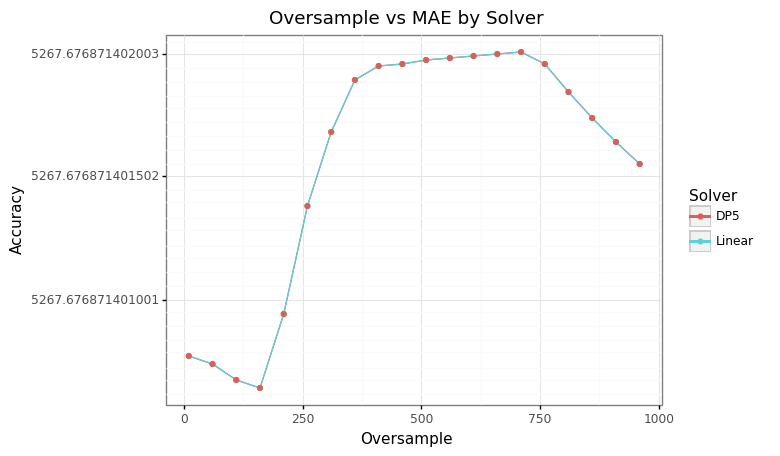

<ggplot: (8727196212767)>

In [76]:
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Accuracy", 
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    + scale_y_log10()
    + ggtitle("Oversample vs MAE by Solver"))

In [78]:
odeint_oversample_resids

,Solver,Oversample,Time (s),Time Var (s),Accuracy,ymin,ymax
0,Linear,10,0.000967,3.704585e-08,5267.676871,0.000967,0.000967
1,Linear,60,0.001934,6.773953e-08,5267.676871,0.001934,0.001934
2,Linear,110,0.001832,5.819344e-08,5267.676871,0.001832,0.001832
3,Linear,160,0.002762,3.809683e-07,5267.676871,0.002762,0.002762
4,Linear,210,0.003035,3.881288e-07,5267.676871,0.003035,0.003036
5,Linear,260,0.003227,3.963149e-07,5267.676871,0.003226,0.003227
6,Linear,310,0.005761,1.154293e-06,5267.676871,0.005760,0.005762
7,Linear,360,0.004623,1.621626e-06,5267.676871,0.004621,0.004624
8,Linear,410,0.006755,2.576524e-06,5267.676871,0.006752,0.006757
9,Linear,460,0.005583,8.883632e-07,5267.676871,0.005582,0.005584


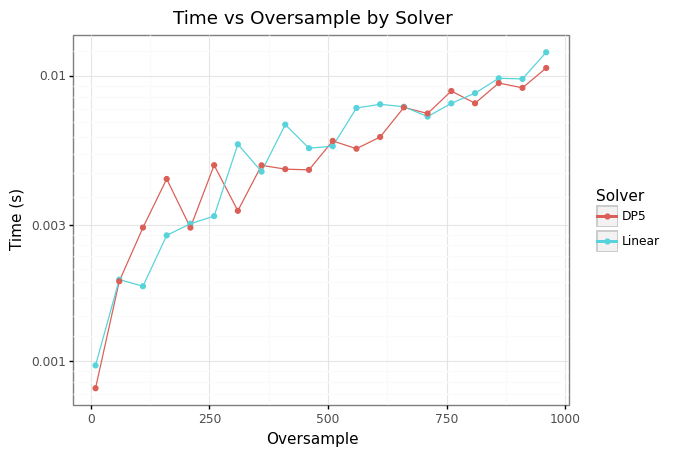

<ggplot: (8727196209553)>

In [77]:
odeint_oversample_resids["ymin"] =\
     odeint_oversample_resids["Time (s)"] -\
     odeint_oversample_resids["Time Var (s)"]

odeint_oversample_resids["ymax"] =\
     odeint_oversample_resids["Time (s)"] +\
     odeint_oversample_resids["Time Var (s)"]

(ggplot(odeint_oversample_resids, \
    aes(x="Oversample", y="Time (s)", ymin="ymin", ymax="ymax", color="Solver"))
    + theme_bw()
    + geom_line()
    + geom_point()
    + geom_errorbar()
    + scale_y_log10()
    + ggtitle("Time vs Oversample by Solver"))

In [32]:
test = generate_model(DP5, 100)

In [8]:
def generate_model(solver, oversample):
    carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    function_object = SingleFitter(carbon_box_model, "Guttler14")
    function_object.load_data("miyake12.csv")
    function_object.compile_production_model(model="simple_sinusoid")
    function_object.set_solver(solver)
    function_object.oversample = oversample
    return function_object


In [12]:
test = generate_model(DP5, 1008)

In [16]:
jacrev(jacrev(test.log_likelihood))(parameters)

In [ ]:

results = {
    "module": [],
    "time": [],
    "time var": [],
    "type": []
}

for solver in odeint:# Iterating through the namespaces of odeint function 
    function_obj = generate_model(odeint[solver], 1008)

    r_profile = profile(function_obj.dc14_fine, parameters)
    results["module"].append(solver)
    results["time"].append(float(r_profile["average"]) * 1000)
    results["type"].append("odeint")

    g_profile = profile(jacrev(function_obj.log_likelihood), parameters)
    results["module"].append(solver)
    results["time"].append(float(g_profile["average"]) * 1000)
    results["type"].append("gradient")

    h_profile = profile(jacrev(jacrev(function_obj.log_likelihood)), parameters)
    results["module"].append(solver)
    results["time"].append(float(h_profile["average"]) * 1000)
    results["type"].append("hessian")

In [ ]:

results = DataFrame(results)  # Switching to a pandas data frame
(ggplot(results, aes(x="module", y="time", fill="type"))
    + geom_col(position="dodge")
    + geom_label(aes(label="round(time)"), position=position_dodge(width=0.9))
    + scale_y_log10()
    + theme_bw())